# Calcium dynamics in a dendritic spine

Here, we implement the model presented in [Bell et al 2019, Journal of General Physiology](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6683673/), in which calcium enters into a dendritic spine through the plasma membrane and is also taken up into a specialized type of endoplasmic reticulum (ER) known as the spine apparatus (SA).

The geometry in this model is divided into 4 domains - two volumes and two surfaces:
- plasma membrane (PM)
- Cytosol
- Spine apparatus membrane (SAm)
- Spine apparatus lumen (volume inside the SA)

In this model, the plasma membrane domain is further divided into multiple subregions:
- postsynaptic density (PSD) - a region rich in receptors and channels associated with neuron activation. In this model, NMDARs are exclusively located at the PSD; in all other cases, this is simply treated as another section of the PM.
- "passive" PM - still contains other channels and receptors; for ease of use here, we label this PM

This model has four species:
- $\text{Ca}^{2+}$ in the cytosol
- fixed buffers ($b_f$) attached to the plasma membrane
- mobile buffers ($b_m$) throughout the cytosol
- $\text{Ca}^{2+}$ in the spine apparatus

In [1]:
import dolfin as d
import sympy as sym
import numpy as np
import logging
import argparse
import pathlib
import sys

from smart import config, mesh, model, mesh_tools, visualization
from smart.units import unit
from smart.model_assembly import (
    Compartment,
    Parameter,
    Reaction,
    Species,
    SpeciesContainer,
    CompartmentContainer,
    sbmodel_from_locals,
)

from matplotlib import pyplot as plt
from dendritic_spine_args import add_run_dendritic_spine_arguments
here = pathlib.Path.cwd()
sys.path.insert(0, (here / ".." / "scripts").as_posix())
import runner as main_run

smart_logger = logging.getLogger("smart")
smart_logger.setLevel(logging.DEBUG)
logger = logging.getLogger("dendritic-spine")
logger.setLevel(logging.INFO)
logger.info("Starting dendritic spine example")
timer = d.Timer("dendritic-spine-example")
d.parameters["form_compiler"]["quadrature_degree"] = 4

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
ROOT -2024-05-12 06:12:21,408 dendritic-spine - INFO - Starting dendritic spine example (4080358839.py:31)


If running a series of tests, we use `argparse` to read in the test conditions. Otherwise, we load default parameters to the `args` dict.

In [2]:
parser = argparse.ArgumentParser()
add_run_dendritic_spine_arguments(parser)
try: # run as python script on cluster
    args = vars(parser.parse_args())
except: # not a run on the cluster
    results_folder = pathlib.Path("results_spine1")
    mesh_file = (here / ".." / "meshes" / "1spine_PM10_PSD11_ERM12_cyto1_ER2_coarser.xml")
    new_mesh = pathlib.Path("mesh/1spine.h5")
    main_run.preprocess_spine_mesh(
        input_mesh_file=mesh_file, output_mesh_file=new_mesh,
        dry_run=False, num_refinements=0)
    args = {}
    args["mesh_file"] = new_mesh    
    args["outdir"] = results_folder
    args["time_step"] = 0.001

receptors_as_param = False

usage: ipykernel_launcher.py [-h] [--mesh-file MESH_FILE] [-o OUTDIR]
                             [-dt TIME_STEP]
ipykernel_launcher.py: error: unrecognized arguments: --f=/root/.local/share/jupyter/runtime/kernel-v2-9195AO8xFsHy97sb.json
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Now, we define various units for this model.

In [3]:
# Aliases - base units
uM = unit.uM
um = unit.um
molecule = unit.molecule
sec = unit.sec
dimensionless = unit.dimensionless
# Aliases - units used in model
D_unit = um**2 / sec
flux_unit = uM * um / sec
vol_unit = uM
surf_unit = molecule / um**2
# electrical units
voltage_unit = unit.millivolt
current_unit = unit.picoampere
conductance_unit = unit.picosiemens

## Load in mesh

We load a realistic spine mesh, including the spine with a postsynaptic density (PSD) and spine apparatus (SA). Note that we store the location of the PSD from the original mesh (facets labeled with the value 11) to the mesh function `facet_markers_orig`, but otherwise, rewrite the mesh so that all of the PM (including the PSD) is treated as a single domain.

In [4]:
parent_mesh = mesh.ParentMesh(
    mesh_filename=str(args["mesh_file"]),
    mesh_filetype="hdf5",
    name="parent_mesh",
    extra_keys=["subdomain0_2", "subdomain1_3"]
)

subdomain0 = parent_mesh.subdomains[0]
subdomain1 = parent_mesh.subdomains[1]
ds = d.Measure("ds", domain=parent_mesh.dolfin_mesh, subdomain_data=subdomain0)
A_PSD = d.assemble_mixed(1.0 * ds(11))
visualization.plot_dolfin_mesh(parent_mesh.dolfin_mesh, subdomain1)

 2024-05-12 06:12:26,533 smart.mesh - INFO - HDF5 mesh, "parent_mesh", successfully loaded from file: mesh/1spine.h5! (mesh.py:245) 
 2024-05-12 06:12:26,948 smart.mesh - INFO - 2 subdomains successfully loaded from file: mesh/1spine.h5! (mesh.py:258) 
ROOT -2024-05-12 06:12:33,431 trame_server.utils.namespace - INFO - Translator(prefix=None) (namespace.py:62)
ROOT -2024-05-12 06:12:33,528 wslink.backends.aiohttp - INFO - awaiting runner setup (__init__.py:103)
ROOT -2024-05-12 06:12:33,529 wslink.backends.aiohttp - INFO - awaiting site startup (__init__.py:110)
ROOT -2024-05-12 06:12:33,534 wslink.backends.aiohttp - INFO - Print WSLINK_READY_MSG (__init__.py:116)
ROOT -2024-05-12 06:12:33,535 wslink.backends.aiohttp - INFO - Schedule auto shutdown with timout 0 (__init__.py:124)
ROOT -2024-05-12 06:12:33,536 wslink.backends.aiohttp - INFO - awaiting running future (__init__.py:127)
ROOT -2024-05-12 06:12:33,546 trame_server.controller - INFO - trigger(trigger__1) (controller.py:69)
RO

Widget(value='<iframe src="http://localhost:36901/index.html?ui=P_0x7f9c9f6dd240_0&reconnect=auto" class="pyvi…

# Model generation

For each step of model generation, refer to SMART Example 3 or API documentation for further details.

We first define compartments and the compartment container. Note that we can specify nonadjacency for surfaces in the model, which is not required, but can speed up the solution process.

In [5]:
Cyto = Compartment("Cyto", 3, um, 1)
PM = Compartment("PM", 2, um, 10)
SA = Compartment("SA", 3, um, 2)
SAm = Compartment("SAm", 2, um, 12)
PM.specify_nonadjacency(["SAm", "SA"])
SAm.specify_nonadjacency(["PM"])

cc = CompartmentContainer()
cc.add([Cyto, PM, SA, SAm])

Define species and place them in a species container. Note that `NMDAR` and `VSCC` are stationary PM surface variables, effectively just serving the role restricting NMDAR calcium influx to the PSD and VSCC influx to the spine (not the dendritic shaft). Additionally, unlike the original model, we consider changes in CaSA rather than treating it as a constant. To account for buffering of the calcium in the SR, we use an effective diffusion coefficient that is much slower than free calcium diffusion and we also rescale all fluxes in and out of the SA (implemented after reaction definitions below). As a rough approximation, we assume a low-affinity buffer ($K_D = 2000 \mu M$) in the SA lumen at a total concentration of $B_{SA,tot} =$ 10 mM. Assuming the buffer has a diffusion coefficient $D_B = 10 \mu m^2/s$, the SA calcium will have an effective diffusion coefficient of:
$$
D_{CaSA,eff} = \frac{K_D}{K_D + B_{SA,tot}}(D_{Ca,free} + \frac{B_{SA,tot}}{K_D} D_B) = 45 \mu m^2/s
$$

Similarly, changes in CaSA due to fluxes in and out of the SA need to be multiplied by the factor:
$$
\xi_{SA} = \frac{1}{1 + B_{SA,tot}/K_D} = 1/6
$$

In [6]:
Ca = Species("Ca", 0.1, vol_unit, 220.0, D_unit, "Cyto")
n_PMr = 0.1011  # vol to surf area ratio for a realistic dendritic spine
# note that NMDAR initial condition is overwritten later to localize to PSD
if receptors_as_param:
    NMDAR = Parameter(
        "NMDAR", 1.0, dimensionless
    )  # specify parameter to localize NMDAR calcium influx to PSD
    VSCC_zThresh = -0.25  # 0.3 #-0.25 for single spine, 0.3 for 2 spine
    VSCC_loc = f"(1 + sign(z - {VSCC_zThresh}))/2"
    VSCC = Parameter.from_expression(
        "VSCC", VSCC_loc, dimensionless
    )  # specify parameter to localize VSCC calcium influx to spine body and neck
else:
    NMDAR = Species(
        "NMDAR", 1.0, dimensionless, 0.0, D_unit, "PM",
    )  # specify species to localize NMDAR calcium influx to PSD
    NMDAR.restrict_to_subdomain(subdomain0, 11)
    VSCC_zThresh = -0.25  # 0.3 #-0.25 for single spine, 0.3 for 2 spine
    VSCC_loc = f"(1 + sign(z - {VSCC_zThresh}))/2"
    VSCC = Species(
        "VSCC", VSCC_loc, dimensionless, 0.0, D_unit, "PM"
    )  # specify species to localize VSCC calcium influx to spine body and neck

Bf = Species("Bf", 78.7*n_PMr, vol_unit * um, 0.0, D_unit, "PM")
Bm = Species("Bm", 20.0, vol_unit, 20.0, D_unit, "Cyto")
CaSA = Species(
    "CaSA", 60.0, vol_unit, 45.0, D_unit, "SA"
)  # effective D due to buffering

2024-05-12 06:12:42,450 smart.model_assembly - DEBUG - Creating dolfin object for space-dependent initial condition VSCC (model_assembly.py:918) 


Define parameters and reactions at the plasma membrane:
* a1: influx of calcium through N-methyl-D-aspartate receptors (NMDARs), localized to the PSD
* a2: calcium entry through voltage-sensitive calcium channels (VSCCs) throughout the PM
* a3: calcium efflux through PMCA (all PM)
* a4: calcium efflux through NCX (all PM)
* a5: calcium binding to immobilized buffers

Calcium entry through NMDARs and VSCCs are given by time-dependent functions. Each depends on the voltage over time, which is specified to match the expected dynamics due to the back-propagating action potential (BPAP) and the excitatory postsynaptic potential (EPSP):

$$
V_m (t) = V_{rest} + BPAP(t) + EPSP(t)\\
= V_{rest} + [BPAP]_{max} \left( I_{bsf} e^{-(t-t_{delay,bp})/t_{bsf}} + I_{bss} e^{-(t-t_{delay,bp})/t_{bss}}\right) + s_{term} \left( e^{-(t-t_{delay})/t_{ep1}} - e^{-(t-t_{delay})/t_{ep2}}\right)
$$

For an overview of the additional equations, refer to the original publication [Bell et al 2019, Journal of General Physiology](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6683673/).

In [7]:
# Both NMDAR and VSCC fluxes depend on the voltage over time
Vrest_expr = -65
Vrest = Parameter("Vrest", Vrest_expr, voltage_unit)
bpmax = 38
Ibsf, tbsf, Ibss, tbss = 0.75, 0.003, 0.25, 0.025
tdelaybp, tdelay = 0.002, 0.0
sterm = 25
tep1, tep2 = 0.05, 0.005
t = sym.symbols("t")
BPAP = (
    bpmax
    * (Ibsf * sym.exp(-(t - tdelaybp) / tbsf) + Ibss * sym.exp(-(t - tdelaybp) / tbss))
    * (1 + sym.sign(t))
    / 2
)
EPSP = (
    sterm
    * (sym.exp(-(t - tdelay) / tep1) - sym.exp(-(t - tdelay) / tep2))
    * (1 + sym.sign(t))
    / 2
)
Vm_expr = Vrest_expr + BPAP + EPSP
# no preintegration for Vm (not a flux)
Vm = Parameter.from_expression(
    "Vm",
    Vm_expr,
    voltage_unit,
    use_preintegration=False,
)
# Define known constants
N_A = 6.022e23  # molecules per mole
F = 96485.332  # Faraday's constant (Coulombs per mole)
Q = 1.602e-19  # Coulombs per elementary charge

n_PMr = Parameter("n_PMr", 0.1011, um)
# NMDAR calcium influx
Vrev_expr = 90
Vrev = Parameter("Vrev", Vrev_expr, voltage_unit)
P0 = 0.5
CaEC = 2  # mM
h = 11.3  # pS/mM
G0 = 65.6  # pS
r = 0.5
ginf = 15.2  # pS
convert_factor = 1e-15  # A/mV per pS
zeta_i = (G0 + r * CaEC * h) / (
    1 + r * CaEC * h / ginf
)  # single channel conductance in pS
G_NMDARVal = convert_factor * zeta_i / (2 * Q)
G_NMDAR = Parameter("G_NMDAR", G_NMDARVal, molecule / (voltage_unit * sec))
If, tau_f, Is, tau_s = 0.5, 0.05, 0.5, 0.2
Km = 0.092  # (1/mV)
Mg, MgScale = 1, 3.57  # mM
B_V = 1 / (1 + sym.exp(-Km * Vm_expr) * Mg / MgScale)
gamma_i_scale = (
    P0 * (If * sym.exp(-t / tau_f) + Is * sym.exp(-t / tau_s)) * B_V * 
    (1+sym.sign(t))/2)
beta_NMDAR = 85
J0_NMDAR_expr = -gamma_i_scale / (beta_NMDAR * A_PSD) # negative sign because of inward current
J0_NMDAR = Parameter.from_expression(
    "J0_NMDAR",
    J0_NMDAR_expr,
    1 / um**2,
    use_preintegration=True,
    numerical_int=True,
)
if receptors_as_param:
    a1 = Reaction(
        "a1",
        [],
        ["Ca"],
        species_map={},
        param_map={"J0": "J0_NMDAR", "G_NMDAR": "G_NMDAR", "Vm": "Vm", "Vrev": "Vrev", "NMDAR": "NMDAR"},
        eqn_f_str="J0*NMDAR*G_NMDAR*(Vm - Vrev)",
        explicit_restriction_to_domain="PM",
    )
    a1.restrict_to_subdomain(subdomain0, 11)
else:
    a1 = Reaction(
        "a1",
        [],
        ["Ca"],
        species_map={"NMDAR": "NMDAR"},
        param_map={"J0": "J0_NMDAR", "G_NMDAR": "G_NMDAR", "Vm": "Vm", "Vrev": "Vrev"},
        eqn_f_str="J0*NMDAR*G_NMDAR*(Vm - Vrev)",
        explicit_restriction_to_domain="PM",
    )
# VSCC calcium influx
gamma = 3.72  # pS
k_Ca = (
    -convert_factor
    * gamma
    * Vm_expr
    * N_A
    * (0.393 - sym.exp(-Vm_expr / 80.36))
    / (2 * F * (1 - sym.exp(Vm_expr / 80.36)))
) # negative for inward current
alpha4, beta4 = 34700, 3680
VSCC_biexp = (sym.exp(-alpha4 * t) - sym.exp(-beta4 * t)) * (1 + sym.sign(t)) / 2
VSCCNum = 2  # molecules/um^2
J_VSCC = Parameter.from_expression(
    "J_VSCC",
    VSCCNum * k_Ca * VSCC_biexp,
    molecule / (um**2 * sec),
    use_preintegration=True,
    numerical_int=True,
)
if receptors_as_param:
    a2 = Reaction(
        "a2",
        [],
        ["Ca"],
        species_map={},
        param_map={"J": "J_VSCC", "VSCC": "VSCC"},
        eqn_f_str="J*VSCC",
        explicit_restriction_to_domain="PM",
    )
else:
    a2 = Reaction(
        "a2",
        [],
        ["Ca"],
        species_map={"VSCC": "VSCC"},
        param_map={"J": "J_VSCC"},
        eqn_f_str="J*VSCC",
        explicit_restriction_to_domain="PM",
    )
# PMCA
Prtote = Parameter("Prtote", 191, vol_unit)
Kme = Parameter("Kme", 2.43, vol_unit)
Prtotex = Parameter("Prtotex", 8.77, vol_unit)
Kmx = Parameter("Kmx", 0.139, vol_unit)
Vmax_lr23 = Parameter("Vmax_lr23", 0.113, vol_unit / sec)
Km_lr23 = Parameter("Km_lr23", 0.442, vol_unit)
Vmax_hr23 = Parameter("Vmax_hr23", 0.59, vol_unit / sec)
Km_hr23 = Parameter("Km_hr23", 0.442, vol_unit)
beta_PMCA = 100
beta_i_str = (
    "(1 + Prtote*Kme/(Kme+c)**2 + Prtotex*Kmx/(Kmx+c)**2)**(-1)"  # buffering term
)
PMCA_str = "Vmax_lr23*c**2/(Km_lr23**2 + c**2) + Vmax_hr23*c**5/(Km_hr23**5 + c**5)"
a3 = Reaction(
    "a3",
    ["Ca"],
    [],
    {
        "Prtote": "Prtote",
        "Prtotex": "Prtotex",
        "Kme": "Kme",
        "Kmx": "Kmx",
        "Vmax_lr23": "Vmax_lr23",
        "Km_lr23": "Km_lr23",
        "Vmax_hr23": "Vmax_hr23",
        "Km_hr23": "Km_hr23",
        "n_PMr": "n_PMr",
    },
    {"c": "Ca"},
    eqn_f_str=f"{beta_PMCA}*({beta_i_str})*({PMCA_str})*n_PMr",
    explicit_restriction_to_domain="PM",
)
# NCX
Vmax_r22 = Parameter("Vmax_r22", 0.1, vol_unit / sec)
Km_r22 = Parameter("Km_r22", 1, vol_unit)  # uM
beta_NCX = 1000
NCX_str = "Vmax_r22*c/(Km_r22 + c)"
a4 = Reaction(
    "a4",
    ["Ca"],
    [],
    {
        "Prtote": "Prtote",
        "Prtotex": "Prtotex",
        "Kme": "Kme",
        "Kmx": "Kmx",
        "Vmax_r22": "Vmax_r22",
        "Km_r22": "Km_r22",
        "n_PMr": "n_PMr",
    },
    {"c": "Ca"},
    eqn_f_str=f"{beta_NCX}*({beta_i_str})*({NCX_str})*n_PMr",
    explicit_restriction_to_domain="PM",
)
# Immobilized buffers
kBf_on = Parameter("kBf_on", 1, 1 / (uM * sec))
kBf_off = Parameter("kBf_off", 2, 1 / sec)
Bf_tot = Parameter("Bf_tot", 78.7 * n_PMr.value, vol_unit * um)
a5 = Reaction(
    "a5",
    ["Ca", "Bf"],
    [],
    {"kon": "kBf_on", "koff": "kBf_off", "Bf_tot": "Bf_tot"},
    eqn_f_str="kon*Ca*Bf - koff*(Bf_tot - Bf)",
    explicit_restriction_to_domain="PM",
)

2024-05-12 06:12:42,604 smart.model_assembly - DEBUG - Time-dependent parameter Vm evaluated from expression. (model_assembly.py:742) 
2024-05-12 06:12:42,670 smart.model_assembly - DEBUG - Time-dependent parameter J0_NMDAR evaluated from expression. (model_assembly.py:742) 
2024-05-12 06:12:42,789 smart.model_assembly - DEBUG - Time-dependent parameter J_VSCC evaluated from expression. (model_assembly.py:742) 


In [8]:
# Create a results folder
result_folder = args["outdir"]
result_folder.mkdir(exist_ok=True, parents=True)

We can plot the time-dependent stimulus from a1-a3 using lambdify.

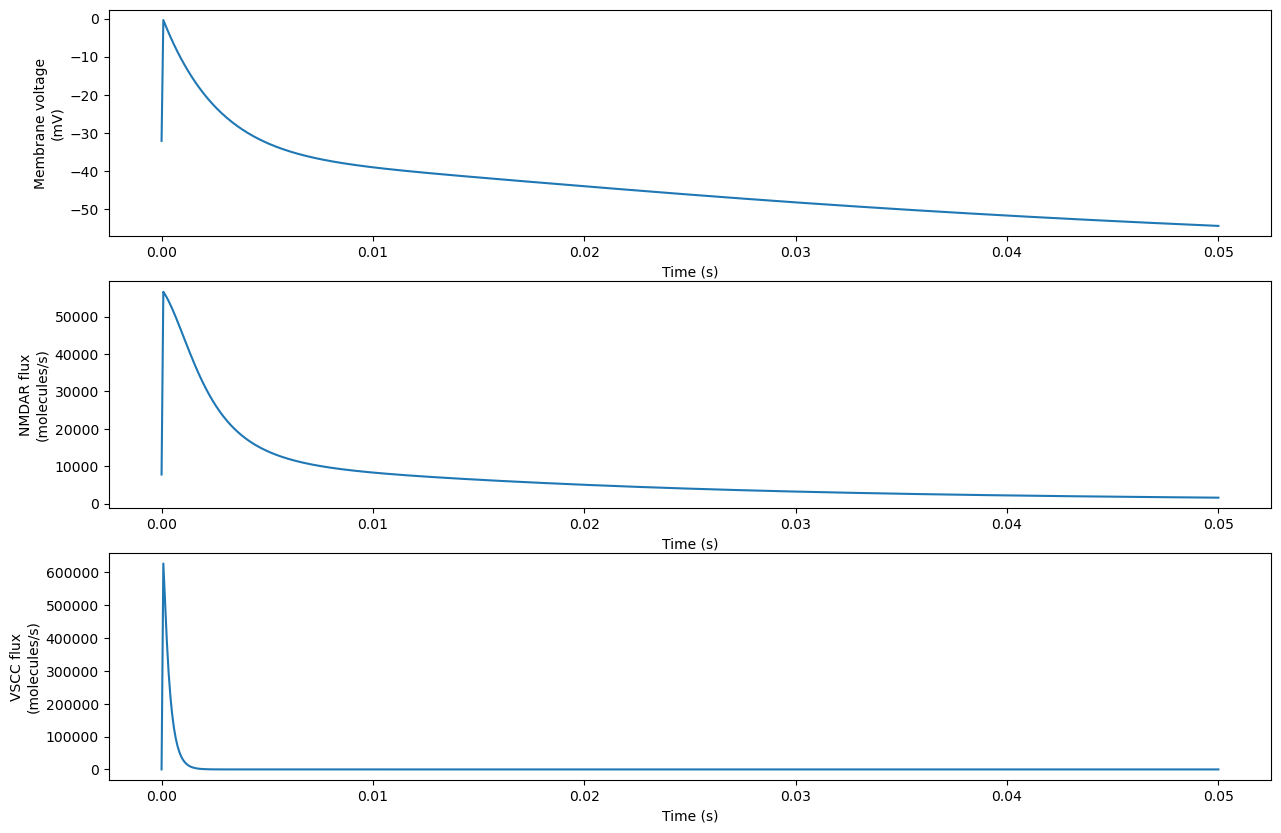

In [9]:
if d.MPI.comm_world.rank == 0:
    from sympy.utilities.lambdify import lambdify

    Vm_func = lambdify(t, Vm_expr, "numpy")  # returns a numpy-ready function
    tArray = np.linspace(-0.0, 0.05, 600)

    fig, ax = plt.subplots(3, 1)
    fig.set_size_inches(15, 10)
    ax[0].plot(tArray, Vm_func(tArray))
    ax[0].set(xlabel="Time (s)", ylabel="Membrane voltage\n(mV)")

    NMDAR_func = lambdify(
        t, A_PSD * J0_NMDAR_expr * G_NMDARVal * (Vm_expr - Vrev_expr), "numpy"
    )
    ax[1].plot(tArray, NMDAR_func(tArray))
    ax[1].set(xlabel="Time (s)", ylabel="NMDAR flux\n(molecules/s)")

    VSCC_func = lambdify(t, 0.8057 * VSCCNum * k_Ca * VSCC_biexp, "numpy")
    # VSCC_func = lambdify(t, VSCC_biexp, 'numpy')
    ax[2].plot(tArray, VSCC_func(tArray))
    ax[2].set(xlabel="Time (s)", ylabel="VSCC flux\n(molecules/s)")
    fig.savefig(result_folder / "time_dependent.png")

Now we define the cytosolic reactions. Here, there is only one reaction: mobile buffer binding calcium (b1). Note that because we assume that the buffering protein and the buffering protein bound to calcium have the same diffusion coefficient, we know that the total amount of buffering protein does not change over time or space, and we can write $[CaB_m] = B_{m,tot} - B_m$

In [10]:
# calcium buffering in the cytosol
kBm_on = Parameter("kBm_on", 1, 1 / (uM * sec))
kBm_off = Parameter("kBm_off", 1, 1 / sec)
Bm_tot = Parameter("Bm_tot", 20, vol_unit)
b1 = Reaction(
    "b1",
    ["Ca", "Bm"],
    [],
    param_map={"kon": "kBm_on", "koff": "kBm_off", "Bm_tot": "Bm_tot"},
    eqn_f_str="kon*Ca*Bm - koff*(Bm_tot - Bm)",
)

Finally, we define reactions associated with the spine apparatus:
* c1: calcium pumping into the SA through SERCA
* c2: calcium leak out of the SA

In [11]:
# SERCA flux
n_SAr = Parameter("n_SAr", 0.0113, um)
Vmax_r19 = Parameter("Vmax_r19", 114, vol_unit / sec)
KP_r19 = Parameter("KP_r19", 0.2, vol_unit)
beta_SERCA = 1000
VmaxSERCA_str = "Vmax_r19*c**2/(KP_r19**2 + c**2)"
c1 = Reaction(
    "c1",
    ["Ca"],
    ["CaSA"],
    {
        "Prtote": "Prtote",
        "Prtotex": "Prtotex",
        "Kme": "Kme",
        "Kmx": "Kmx",
        "Vmax_r19": "Vmax_r19",
        "KP_r19": "KP_r19",
        "n_SAr": "n_SAr",
    },
    {"c": "Ca"},
    eqn_f_str=f"{beta_SERCA}*({beta_i_str})*({VmaxSERCA_str})*n_SAr",
    explicit_restriction_to_domain="SAm",
)
# calcium leak out of the SA
k_leak = Parameter("k_leak", 0.1608, 1 / sec)
c2 = Reaction(
    "c2",
    ["CaSA"],
    ["Ca"],
    {"k_leak": "k_leak", "n_SAr": "n_SAr"},
    {"c": "Ca", "cSA": "CaSA"},
    eqn_f_str="k_leak*(cSA - c)*n_SAr",
    explicit_restriction_to_domain="SAm",
)

xi = 1/6  # scaling factor to account for rapid buffering in SA (see above)
for c in [c1, c2]:
    c.flux_scaling = {"CaSA": xi}
    c.__post_init__()

Now we add all parameters and reactions to their SMART containers.

In [12]:
pc, sc, cc, rc = sbmodel_from_locals(locals().values())

Initialize model and solver.

In [13]:
configCur = config.Config()
configCur.flags.update({"allow_unused_components": True})
model_cur = model.Model(pc, sc, cc, rc, configCur, parent_mesh)
configCur.solver.update(
    {
        "final_t": 0.025,
        "initial_dt": args["time_step"],
        "time_precision": 8,
        "use_snes": True,
    }
)

if model_cur.mpi_comm_world.rank == 0:
    import json
    # Dump config to results folder
    (result_folder / "config.json").write_text(
        json.dumps(
            {
                "solver": configCur.solver.__dict__,
                "flags": configCur.flags.__dict__,
                "reaction_database": configCur.reaction_database,
                "mesh_file": str(args["mesh_file"]),
                "outdir": str(args["outdir"]),
                "time_step": args["time_step"],
                
            }
        )
    )
    model_cur.to_pickle(result_folder / "model_cur.pkl")


model_cur.initialize(initialize_solver=True)




 2024-05-12 06:12:43,650 smart.model - DEBUG - Checking validity of model (step 1 of ZZ) (model.py:256) 


2024-05-12 06:12:43,652 smart.model - DEBUG - Check that mesh/compartment dimensionalities match (model.py:347) 
2024-05-12 06:12:43,653 smart.model - DEBUG - Checking for namespace conflicts (model.py:383) 
 2024-05-12 06:12:43,654 smart.model - DEBUG - Step 1 of initialization completed successfully! (model.py:260) 



 2024-05-12 06:12:43,656 smart.model - DEBUG - Cross-Container Dependent Initializations (step 2 of ZZ) (model.py:270) 


2024-05-12 06:12:43,656 smart.model - DEBUG - Turning reactions into unsigned symbolic flux strings (model.py:436) 
2024-05-12 06:12:43,816 smart.model - DEBUG - Make sure all reactions have parameters/species defined (model.py:486) 
2024-05-12 06:12:43,891 smart.model - DEBUG - Linking parameters, species, and compartments to reactions (model.py:516) 
2024-05-12 06:12:43,892 smart.model - DEBUG - Checking for unused parameters, species, or 

 2024-05-12 06:12:46,151 smart.model_assembly - DEBUG - DEBUGGING INTEGRATION MEASURE (only fully defined domains are enabled for now) (model_assembly.py:1660) 
2024-05-12 06:12:46,190 smart.model_assembly - DEBUG - Getting fluxes for reaction a5 (model_assembly.py:1361) 
 2024-05-12 06:12:46,207 smart.model_assembly - DEBUG - DEBUGGING INTEGRATION MEASURE (only fully defined domains are enabled for now) (model_assembly.py:1660) 
 2024-05-12 06:12:46,240 smart.model_assembly - DEBUG - DEBUGGING INTEGRATION MEASURE (only fully defined domains are enabled for now) (model_assembly.py:1660) 
2024-05-12 06:12:46,246 smart.model_assembly - DEBUG - Getting fluxes for reaction b1 (model_assembly.py:1361) 
2024-05-12 06:12:46,286 smart.model_assembly - DEBUG - Getting fluxes for reaction c1 (model_assembly.py:1361) 
2024-05-12 06:12:46,287 smart.model_assembly - DEBUG - Flux c1: stoichiometry/flux for species CaSA scaled by 0.16666666666666666 (model_assembly.py:1374) 
 2024-05-12 06:12:46,303 

╒════╤═════════════╤══════╤══════════════════╤═════════════╤══════════════╤════════════════╕
│    │ name        │   id │   dimensionality │   num_cells │   num_facets │   num_vertices │
╞════╪═════════════╪══════╪══════════════════╪═════════════╪══════════════╪════════════════╡
│  0 │ parent_mesh │    0 │                3 │      106979 │       215706 │          18649 │
├────┼─────────────┼──────┼──────────────────┼─────────────┼──────────────┼────────────────┤
│  1 │ Cyto        │   22 │                3 │       81206 │       171996 │          17742 │
├────┼─────────────┼──────┼──────────────────┼─────────────┼──────────────┼────────────────┤
│  2 │ PM          │   29 │                2 │        3243 │         4904 │           1661 │
├────┼─────────────┼──────┼──────────────────┼─────────────┼──────────────┼────────────────┤
│  3 │ SA          │   35 │                3 │       25773 │        59382 │           8727 │
├────┼─────────────┼──────┼──────────────────┼─────────────┼──────────

Initialize XDMF files for saving results, save model information to .pkl file, then solve the system until `model_cur.t > model_cur.final_t`

In [14]:
# Write initial condition(s) to file
results = dict()
for species_name, species in model_cur.sc.items:
    results[species_name] = d.XDMFFile(
        model_cur.mpi_comm_world, str(result_folder / f"{species_name}.xdmf")
    )
    results[species_name].parameters["flush_output"] = True
    results[species_name].write(model_cur.sc[species_name].u["u"], model_cur.t)

# Set loglevel to warning in order not to pollute notebook output
smart_logger.setLevel(logging.WARNING)
concVec = np.array([model_cur.sc["Ca"].initial_condition])
cytoMesh = model_cur.cc["Cyto"].dolfin_mesh

int_domain = d.MeshFunction("size_t", cytoMesh, 3)

dx = d.Measure("dx", domain=cytoMesh)
int_domain = d.MeshFunction("size_t", cytoMesh, 3)
for i in range(len(int_domain.mesh().coordinates())):
    if int_domain.mesh().coordinates()[i][2] > 0.5:
        int_domain.array()[i] = 1
dx_int = d.Measure("dx", domain=cytoMesh, subdomain_data=int_domain)
int_vol = d.assemble_mixed(1.0*dx_int(1))
gradVec = np.array([d.assemble_mixed(d.grad(model_cur.sc["Ca"].u["u"])[2]*dx_int(1))/int_vol])
tvec = np.array([0.0])
# Solve
displayed = False
while True:
    logger.info(f"Solve for time step {model_cur.t}")
    # Solve the system
    model_cur.monolithic_solve()
    # Save results for post processing
    for species_name, species in model_cur.sc.items:
        results[species_name].write(model_cur.sc[species_name].u["u"], model_cur.t)
    int_val = d.assemble_mixed(model_cur.sc["Ca"].u["u"] * dx)
    volume = d.assemble_mixed(1.0 * dx)
    curConc = np.array([int_val / volume])
    int_val_grad = d.assemble_mixed(d.grad(model_cur.sc["Ca"].u["u"])[2]*dx_int(1))
    curGrad = np.array([int_val_grad / int_vol])
    concVec = np.concatenate((concVec, curConc))
    gradVec = np.concatenate((gradVec, curGrad))
    tvec = np.concatenate((tvec, np.array([float(model_cur.t)])))

    if model_cur.mpi_comm_world.rank == 0:
        np.savetxt(result_folder / "tvec.txt", np.array(model_cur.tvec).astype(np.float32))
        if model_cur.t > 0.025 and not displayed:  # display first time after .025 s
            visualization.plot(model_cur.sc["Ca"].u["u"])
            displayed = True
    # End if we've passed the final time
    if model_cur.t >= model_cur.final_t:
        break

 2024-05-12 06:20:11,446 smart.model_assembly - INFO - \begin{longtable}{lllllll}
\toprule
 & Dimensionality & Species & Vertices & Cells & Marker value & Size \\
\midrule
\endfirsthead
\toprule
 & Dimensionality & Species & Vertices & Cells & Marker value & Size \\
\midrule
\endhead
\midrule
\multicolumn{7}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
Cyto & 3 & 2 & 17742 & 81206 & 1 & $\SI[]{6.463e-01}{\micro\meter\cubed}$ \\
PM & 2 & 3 & 1661 & 3243 & 10 & $\SI[]{6.236e+00}{\micro\meter\squared}$ \\
SA & 3 & 1 & 8727 & 25773 & 2 & $\SI[]{2.692e-02}{\micro\meter\cubed}$ \\
SAm & 2 & 0 & 7820 & 15672 & 12 & $\SI[]{2.387e+00}{\micro\meter\squared}$ \\
\end{longtable}
 (model_assembly.py:307) 
 2024-05-12 06:21:47,793 smart.model_assembly - INFO - \begin{longtable}{llll}
\toprule
 & Compartment & D & Initial condition \\
\midrule
\endfirsthead
\toprule
 & Compartment & D & Initial condition \\
\midrule
\endhead
\midrule
\multicolumn{4}{r}{Continued on next pa

KeyboardInterrupt: 

: 

Plot the average calcium over time and save results.

In [ ]:
if model_cur.mpi_comm_world.size > 1:
    d.MPI.comm_world.Barrier()

timer.stop()
timings = d.timings(
    d.TimingClear.keep,
    [d.TimingType.wall, d.TimingType.user, d.TimingType.system],
).str(True)
print(timings)
(result_folder / "timings.txt").write_text(timings)

if model_cur.mpi_comm_world.rank == 0:
    fig, ax = plt.subplots()
    ax.plot(tvec, concVec)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Cytosolic calcium (μM)")
    fig.savefig(result_folder / "ca2+-example.png")
    np.save(result_folder / "tvec.npy", tvec)
    np.save(result_folder / "concVec.npy", concVec)
    np.save(result_folder / "gradVec.npy", gradVec)
    auc_cur = np.trapz(concVec, tvec)
    print(auc_cur)
